Functions

In [254]:
#Function to test for stationarity
def adfuller_test(series, sig=0.05, name=''):
    res = adfuller(series, autolag='AIC')
    p_value = round(res[1], 3)

    if p_value <= sig:
        print(f" {name} : P-Value = {p_value} => Stationary. ")
    else:
        print(f" {name} : P-Value = {p_value} => Non-stationary.")

In [255]:
#Function to split dataset based on date selected
def train_test_split(df, enddate_train,startdate_test):
    df_train = df[:enddate_train]
    df_test = df[startdate_test:]
    return df_train, df_test

In [256]:
#Function extract X and Y from dataset ADJUST which X variables we want
def X_Y_transform(df):
    #X = df[['Corn Price Futures','OIL_PRICE $/bbl','OBS_VALUE_QUANTITY_TON']]
    X = df[['AVG_TAVG',
            'Corn Price Futures',
            'OBS_VALUE_QUANTITY_TON',
            'OIL_PRICE $/bbl',
            'unemployment_total']]
    Y = df['price']
    return X, Y

In [257]:
#Function ARIMAX multi step forecast
def arimax_forecast(history, future, config, step_size):
    order, trend = config
    # define model
    X_train,Y_train = X_Y_transform(history)
    X_test,Y_test = X_Y_transform(future)
    model = ARIMA(endog = Y_train, exog = X_train, order=order, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit()
    #results = ARMAResults(model = model, params =  model_fit)
    #print("aic and  bic values", model.aic, model.bic)
    # multistep forecast
    y_hat = model_fit.predict(len(history), (len(history)+step_size-1) , exog=X_test)
    return y_hat

In [258]:
#Function Moving window for univariate data
def moving_window(df, step, cfg):
    print("Fitting the combination", cfg)
    predictions = []
    history_size, step_size = step
    history = df[:history_size]
    future = df[history_size:(history_size+step_size)]

    # step over each time-step in the test set
    for i in range(int(math.ceil((len(df)-history_size)/6))):
        # fit model and make forecast for history
        if len(future) < step_size:
            step_size = len(future)

        yhat = arimax_forecast(history, future, cfg, step_size)
        # store forecast in list of predictions
        if i == 0:
            predictions = yhat
        else:
            predictions = predictions.append(yhat)
        # move the history and forecast window
        history = history.append(future)
        history = history[step_size:]
        future = df[(history_size+(step_size*(i+1))):(history_size+(step_size*(i+2)))]

    # estimate prediction error
    future = df[history_size:]
    X_test,Y_test = X_Y_transform(future)
    score = evaluation_measures(Y_test, predictions)
    #print(predictions)
    print(score)
    return score, predictions

In [259]:
#Function performance measures
def evaluation_measures(actual, predicted):
    mse = np.square(np.subtract(actual, predicted)).mean()
    return mse

In [260]:
#Function to  create a set of arimax configs to try
def arima_config(p,q):
    models = list()
    # define config lists
    p_params = list(range(1,p))
    d_params = [0,1]
    q_params = list(range(1,q))
    t_params = ['n']
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    cfg = [(p,d,q), t]
                    models.append(cfg)
    return models

In [261]:
#Function run grid search configs
def grid_search(df, cfg_list, step):
    scores = list()
    filterwarnings("ignore")
    best_score = np.inf
    best_prediction = list()
    best_cfg = list()

    for cfg in cfg_list:
        score, prediction = moving_window(df, step, cfg)
        scores.append(score)

        if score < best_score:
            print("Found an improved score", score,"is better than", best_score )
            best_score = score
            best_cfg = cfg
            best_prediction = prediction

    return best_cfg, best_score, best_prediction

In [262]:
#Function take log of price and standardize
def transform_data(df):
    df['price'] = np.log(df['price'])
    col_list = df.columns
    #mean_list = []
    #sd_list = []
    mean_p = 0
    sd_p = 0

    for col in col_list:
        if col == 'price':
            mean_p = st.mean(df[col])
            sd_p = st.pstdev(df[col])
            df[col] = (df[col]-mean_p)/sd_p
        else:
            mean = st.mean(df[col])
            sd = st.pstdev(df[col])
            df[col] = (df[col]-mean)/sd

    if mean_p == 0:
        print("Warning: price variable not found")
    return df, mean_p, sd_p

Main code

In [270]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import numpy as np
from warnings import filterwarnings
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import math
import statistics as st
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

Pre examination of model

In [264]:
df_maize = pd.read_excel('MAIZE_FILTERED_2023-02-25_19-36-41.xlsx', header=[0, 1], index_col=0) #ADJUST to product
country_list = list(df_maize.columns.levels[1])
country_list

['Brazil', 'France', 'Germany', 'Hungary', 'Ukraine']

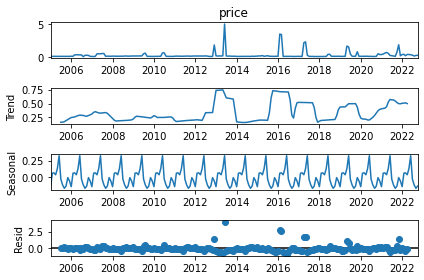

  : P-Value = 0.0 => Stationary. 


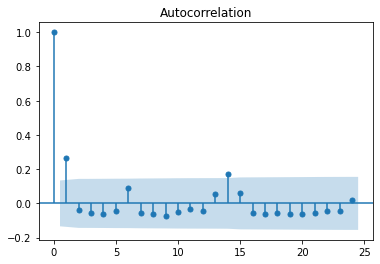

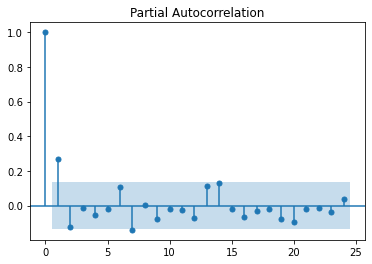

In [265]:
country = 'Brazil'
df = df_maize.xs(country, axis = 1, level =1 , drop_level=True) #ADJUST to country

#Stationairity
decom = sm.tsa.seasonal_decompose(df.price, model='additive')
decom.plot()
plt.show()

price_diff = df.price.diff()
price_diff[0] = 0
adfuller_test(price_diff) #Chose the max d order

#ACF/PCF
plot_acf(df.price) #Chose the max p order
plt.show()

plot_pacf(df.price) #Chose the max q order
plt.show()

Main code

In [266]:
if __name__ == '__main__':
    #Import data of the required product
    df_maize = pd.read_excel('MAIZE_FILTERED_2023-02-25_19-36-41.xlsx', header=[0, 1], index_col=0) #ADJUST to product

    #Select which country dataset you want to forcast
    #variable_list = list(df_maize.columns.levels[0])
    country_list = list(df_maize.columns.levels[1])
    country = 'Brazil'
    df = df_maize.xs(country, axis = 1, level =1 , drop_level=True) #ADJUST to country

    #split the data in test and train
    enddate_train = "2022-04-01"
    startdate_test = "2019-11-01"

    #df_train, df_test = train_test_split(df, enddate_train,startdate_test )
    df_train_unedited, df_test_unedited = train_test_split(df, enddate_train,startdate_test )

    #take log price and standardize the data
    df_train = df_train_unedited.copy()
    df_train, mean_p, sd_p = transform_data(df_train)
    df_test = df_test_unedited.copy()
    df_test, mean_tp, sd_tp = transform_data(df_test)

    # model configs
    p = 2
    q = 2
    cfg_list = arima_config(p,q)
    step = [24,6] #history horizon and multistepforecast

    # grid search on train dataset with minimum MSE
    best_cfg, lowest_score, predictions_train = grid_search(df_train, cfg_list,step)
    print('Gridsearch found with best parameters', best_cfg, "with MSE equal to", lowest_score)


Fitting the combination [(1, 0, 1), 'n']
2.710309090522888
Found an improved score 2.710309090522888 is better than inf
Fitting the combination [(1, 1, 1), 'n']
4.361843736594379
Gridsearch found with best parameters [(1, 0, 1), 'n'] with MSE equal to 2.710309090522888


Post fit evaluation

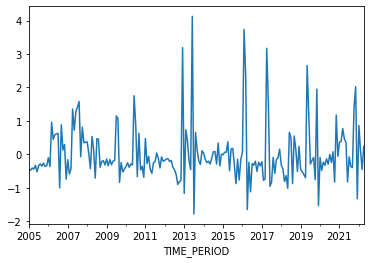

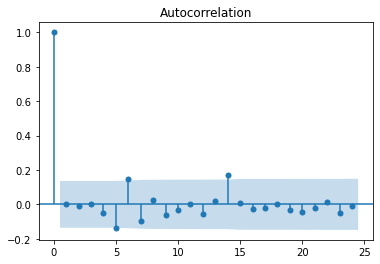

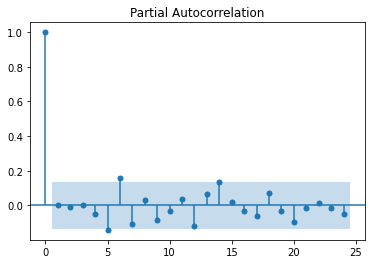

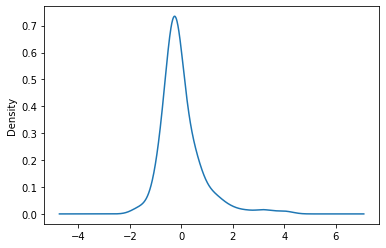

count    208.000000
mean      -0.000993
std        0.831797
min       -1.783588
25%       -0.431784
50%       -0.202603
75%        0.239685
max        4.127247
dtype: float64


In [267]:
#Fit on full model
order_b, trend_b = best_cfg
# define model
X_train, Y_train = X_Y_transform(df_train)
model_b = ARIMA(endog = Y_train, exog = X_train, order=order_b, trend=trend_b, enforce_stationarity=False, enforce_invertibility=False)
# fit model
model_fit_b = model_b.fit()

# Print the model summary
#print(model_fit_b.summary())

# line plot of residuals
residuals = model_fit_b.resid
residuals.plot()
plt.show()

#ACF/PCF
plot_acf(residuals) #Chose the max p order
plt.show()

plot_pacf(residuals) #Chose the max q order
plt.show()

# density plot of residuals
residuals.plot(kind='kde')
plt.show()

# summary stats of residuals
print(residuals.describe())


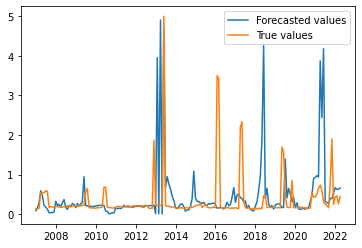

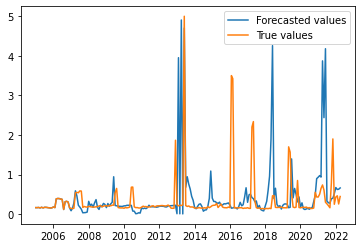

In [268]:
#Visulaize the train results
predictions_train_destandardize = np.exp(predictions_train*sd_p+mean_p)

#plot only forcast horizon
plt.plot(predictions_train_destandardize,label='Forecasted values')
plt.plot(df_train_unedited.price[step[0]:],label='True values')
plt.legend()
plt.show()

#plot on full period
trueprices = df_train_unedited.price
forecasted_prices = trueprices[:len(trueprices)-len(predictions_train_destandardize)]
forecasted_prices = forecasted_prices.append(predictions_train_destandardize)


plt.plot(forecasted_prices,label='Forecasted values')
plt.plot(trueprices,label='True values')
plt.legend()
plt.show()

Evaluation on Test

Fitting the combination [(1, 0, 1), 'n']
1.0136322524270658
For Brazil with orders [(1, 0, 1), 'n'] we find MSE: 1.0136322524270658 MAE: 0.7386221353532304 MAPE: 3.0809005917690997


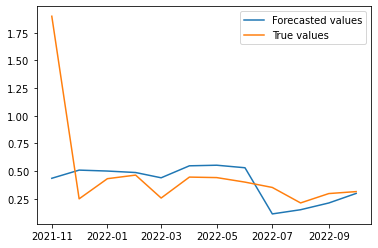

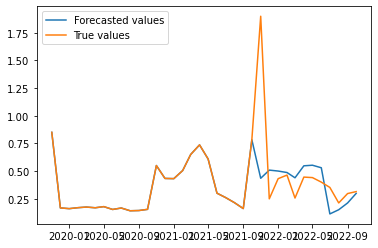

In [272]:
#Run test set
df_test = df_test_unedited.copy()
df_test, mean_tp, sd_tp = transform_data(df_test)
score_test, predictions_test = moving_window(df_test, step, best_cfg)

predictions_test_destandardize = np.exp(predictions_test*sd_tp+mean_tp)

#measures MSE, MAE,MAPE
#MSE = mean_squared_error(df_test_unedited.price[step[0]:], predictions_test_destandardize)
#MAE = mean_absolute_error(df_test_unedited.price[step[0]:], predictions_test_destandardize)
#MAPE = mean_absolute_percentage_error(df_test_unedited.price[step[0]:], predictions_test_destandardize)

MSE = mean_squared_error(df_test.price[step[0]:], predictions_test)
MAE = mean_absolute_error(df_test.price[step[0]:], predictions_test)
MAPE = mean_absolute_percentage_error(df_test.price[step[0]:], predictions_test)

print("For",country,"with orders",best_cfg,"we find MSE:", MSE,"MAE:",MAE,"MAPE:",MAPE)
#Visulaize the test results

#plot only forcast horizon

plt.plot(predictions_test_destandardize,label='Forecasted values')
plt.plot(df_test_unedited.price[step[0]:],label='True values')
plt.legend()
plt.show()

#plot on full period
trueprices_t = df_test_unedited.price
forecasted_pricest = trueprices_t[:len(trueprices_t)-len(predictions_test_destandardize)]
forecasted_pricest = forecasted_pricest.append(predictions_test_destandardize)


plt.plot(forecasted_pricest,label='Forecasted values')
plt.plot(trueprices_t,label='True values')
plt.legend()
plt.show()